# Proximal Policy Optimization
In this notebook we implementing Proximal Policy Optimization algorithm

In [ ]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

    !pip -q install gymnasium[mujoco]==1.0.0

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

## Environment

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym
from collections import defaultdict
import numpy as np

ENV_NAME = "HalfCheetah-v5"


def make_env(**kwargs):
    return gym.make(ENV_NAME, **kwargs)


env = make_env(render_mode="rgb_array")
print("Observation space: ", env.observation_space)
print("Action space: ", env.action_space)

Observation space:  Box(-inf, inf, (17,), float64)
Action space:  Box(-1.0, 1.0, (6,), float32)


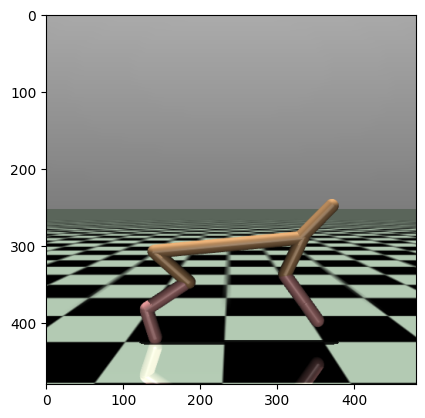

In [ ]:
state, info = env.reset(seed=0)
plt.imshow(env.render())

We use a vectorized env to collect transitions in parallel.

In [ ]:
from gymnasium.vector import AsyncVectorEnv
from gymnasium.wrappers.vector import (
    NormalizeObservation,
    NormalizeReward,
    ClipReward,
    RecordEpisodeStatistics,
)


def make_vec_env(num_envs, **kwargs):

    env_fns = [lambda: make_env(**kwargs) for i in range(num_envs)]
    envs = AsyncVectorEnv(env_fns, shared_memory=True)
    envs = RecordEpisodeStatistics(envs, buffer_length=100000)
    envs = NormalizeObservation(envs)
    envs = NormalizeReward(envs, gamma=0.99)
    envs = ClipReward(envs, min_reward=-10, max_reward=10)
    return envs

# Parameters
n_envs = 2  # Number of parallel environments
vec_env = make_vec_env(n_envs)

## Policy model

In [ ]:
# import tensorflow as tf
import torch

from torch import nn
from torch.nn import functional as F
import torch


class PolicyModel(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.h = 64
        self.action_dim = action_dim

        self.policy_model = nn.Sequential(
                            nn.Linear(state_dim, self.h),
                            nn.Tanh(),
                            nn.Linear(self.h, self.h),
                            nn.Tanh(),
                            nn.Linear(self.h, self.h),
                            nn.Tanh(),
                            nn.Linear(self.h, 2 * action_dim)
                        )

        self.value_model = nn.Sequential(
                            nn.Linear(state_dim, self.h),
                            nn.Tanh(),
                            nn.Linear(self.h, self.h),
                            nn.Tanh(),
                            nn.Linear(self.h, self.h),
                            nn.Tanh(),
                            nn.Linear(self.h, 1)
                        )
        self.softplus = nn.Softplus()

    def get_policy(self, x):
        out = self.policy_model(x)
        mean = out[:, : self.action_dim]
        var = self.softplus(out[:, self.action_dim : ])
        return mean, var

    def get_value(self, x):
        out = self.value_model(x)
        return out

    def forward(self, x):
        policy = self.get_policy(x)
        value = self.get_value(x)

        return policy, value

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
from torch.distributions.multivariate_normal import MultivariateNormal

class Policy:
    def __init__(self, model):
        self.model = model

    def act(self, inputs, training=False):
        inputs = torch.tensor(inputs, dtype=torch.float32, device="cuda")

        mean, var = self.model.get_policy(inputs)
        cov_matrix = torch.stack([torch.diag(var[i]) for i in range(var.shape[0])])
        normal_distr = MultivariateNormal(mean, cov_matrix)

        actions = normal_distr.sample()
        log_probs = normal_distr.log_prob(actions)

        values = self.model.get_value(inputs)

        if training:
            return {"distribution": normal_distr, "values": values.squeeze()}

        return {
            "actions": actions.cpu().numpy().squeeze(),
            "log_probs": log_probs.detach().cpu().numpy().squeeze(),
            "values": values.detach().cpu().numpy().squeeze(),
        }

We will use `EnvRunner` to perform interactions with an environment with a policy for a fixed number of timesteps. 

In [ ]:
class AsArray:
    """
    Converts lists of interactions to ndarray.
    """
    def __call__(self, trajectory):
        for k, v in filter(lambda kv: kv[0] != "state", trajectory.items()):
            trajectory[k] = np.asarray(v)

In [ ]:
""" RL env runner """
class EnvRunner:
    """Reinforcement learning runner in an environment with given policy"""

    def __init__(self, env, policy, rollout_length, transforms=None, step_var=None):
        self.env = env
        self.policy = policy
        self.rollout_length = rollout_length
        self.transforms = transforms or []
        self.step_var = step_var if step_var is not None else 0
        self.state = {"latest_observation": self.env.reset()[0]}

    @property
    def num_envs(self):
        """Returns number of batched envs or `None` if env is not batched"""
        return getattr(self.env, "num_envs", None)

    def reset(self, **kwargs):
        """Resets env and runner states."""
        self.state["latest_observation"], info = self.env.reset(**kwargs)
        self.policy.reset()

    def get_next(self):
        """Runs the agent in the environment."""
        trajectory = defaultdict(list, {"actions": []})
        observations = []
        rewards = []
        resets = []
        self.state["env_steps"] = self.rollout_length

        for i in range(self.rollout_length):

            observations.append(self.state["latest_observation"])
            act = self.policy.act(self.state["latest_observation"])

            if "actions" not in act:
                raise ValueError(
                    "result of policy.act must contain 'actions' "
                    f"but has keys {list(act.keys())}"
                )
            for key, val in act.items():
                trajectory[key].append(val)

            obs, rew, terminated, truncated, _ = self.env.step(
                trajectory["actions"][-1]
            )
            done = np.logical_or(terminated, truncated)
            self.state["latest_observation"] = obs
            rewards.append(rew)
            resets.append(done)
            self.step_var += self.num_envs or 1
            if not self.num_envs and np.all(done):
                self.state["env_steps"] = i + 1
                self.state["latest_observation"] = self.env.reset()[0]

        trajectory.update(observations=observations, rewards=rewards, resets=resets)
        trajectory["state"] = self.state

        for transform in self.transforms:
            transform(trajectory)
        return trajectory

##  Generalized Advantage Estimator

 [Generalized Advantage Estimator](https://arxiv.org/abs/1506.02438). In GAE the advantages
$A_t^{\mathrm{GAE}(\gamma,\lambda)}$ are essentially defined as the exponential
moving average with parameter $\lambda$ of the regular advantages
$\hat{A}^{(T)}(s_t) = \sum_{l=0}^{T-t-1} \gamma^l r_{t+l} + \gamma^{T} V^\pi(s_{T}) - V^\pi(s_t)$.
The exact formula for the computation is the following

$$
A_{t}^{\mathrm{GAE}(\gamma,\lambda)} = \sum_{l=0}^{T-t-1} (\gamma\lambda)^l\delta_{t + l}^V, \, t \in [0, T)
$$
where $\delta_{t+l}^V = r_{t+l} + \gamma V^\pi(s_{t+l+1}) - V^\pi(s_{t+l})$.

---


Once we computed the advantages, we can get the targets for training the value function by adding
back values:
$$
\hat{V}(s_{t}) = A_{t}^{\mathrm{GAE}(\gamma,\lambda)} + V(s_{t}),
$$
where $\hat{V}$ is a tensor of value targets that are used to train the value function.

In [ ]:
class GAE:

    def __init__(self, policy, gamma=0.99, lambda_=0.95):
        self.policy = policy
        self.gamma = gamma
        self.lambda_ = lambda_

    def __call__(self, trajectory):

        T = trajectory['observations'].shape[0]
        last_state = trajectory['state']["latest_observation"]
        input = torch.tensor(last_state, dtype=torch.float32, device="cuda")
        last_value = np.array(self.policy.model.get_value(input).detach().cpu())
        trajectory['values'] = np.concatenate([trajectory['values'], np.transpose(last_value)], axis=0)

        num_envs = trajectory['observations'].shape[1]
        gae = []

        for i in range(num_envs):
            rewards = trajectory['rewards'][:, i]
            values = trajectory['values'][:, i]
            resets = trajectory['resets'][:, i]
            td = rewards + self.gamma * values[1 : ] * (1 - resets) - values[ : -1]
            adv = np.zeros(T)
            adv[-1] = td[-1]
            for j in range(2, T+1):
                adv[-j]  = adv[-j + 1] * self.lambda_ * self.gamma * (1 -  resets[-j]) + td[-j]
            gae.append(adv)

        trajectory['advantages'] = np.transpose(np.stack(gae))
        trajectory['value_targets'] = trajectory['advantages']  +  trajectory['values'][:-1, :]


The main advantage of PPO over simpler policy based methods like A2C is that it is possible
to train on the same trajectory for multiple gradient steps. The following class wraps
an `EnvRunner`.

In [ ]:
def flatten_first_two_dims(arr):
    if arr.ndim == 2:
        return arr.reshape(-1)
    return arr.reshape(arr.shape[0] * arr.shape[1], *arr.shape[2:])

class TrajectorySampler:
    """Samples minibatches from trajectory for a number of epochs."""

    def __init__(self, runner, num_epochs, num_minibatches, transforms=None):
        self.runner = runner
        self.num_epochs = num_epochs
        self.num_minibatches = num_minibatches
        self.transforms = transforms or []
        self.minibatch_count = 0
        self.epoch_count = 0
        self.trajectory = None

    def shuffle_trajectory(self):
        """Shuffles all elements in trajectory. """
        trajectory_len = len(self.trajectory["observations"])
        permutation = np.random.permutation(trajectory_len)
        for key, value in self.trajectory.items():
            if key != "state":
                self.trajectory[key] = value[permutation]

    def squeeze_trajectory(self):
        for key, value in self.trajectory.items():
            if key != "state":
                self.trajectory[key] = flatten_first_two_dims(value)

    def get_trajectory(self):
        self.trajectory = self.runner.get_next()
        self.squeeze_trajectory()

    def get_next(self):
        """Returns next minibatch."""
        if not self.trajectory:
            self.get_trajectory()

        if self.minibatch_count == self.num_minibatches:
            self.shuffle_trajectory()
            self.minibatch_count = 0
            self.epoch_count += 1

        if self.epoch_count == self.num_epochs:
            self.get_trajectory()
            self.shuffle_trajectory()
            self.minibatch_count = 0
            self.epoch_count = 0

        trajectory_len = self.trajectory["observations"].shape[0]

        batch_size = trajectory_len // self.num_minibatches

        minibatch = {}
        for key, value in self.trajectory.items():
            if key != "state":
                minibatch[key] = value[
                    self.minibatch_count
                    * batch_size : (self.minibatch_count + 1)
                    * batch_size
                ]

        self.minibatch_count += 1

        for transform in self.transforms:
            transform(minibatch)

        return minibatch

Finally, we can create our PPO sampler.

In [ ]:
def make_ppo_sampler(
    env,
    policy,
    num_runner_steps=2048,
    gamma=0.99,
    lambda_=0.95,
    num_epochs=10,
    num_minibatches=32,
):
    """Creates runner for PPO algorithm."""
    runner_transforms = [AsArray(), GAE(policy, gamma=gamma, lambda_=lambda_)]
    runner = EnvRunner(env, policy, num_runner_steps, transforms=runner_transforms)

    sampler_transforms = [NormalizeAdvantages()]
    sampler = TrajectorySampler(
        runner,
        num_epochs=num_epochs,
        num_minibatches=num_minibatches,
        transforms=sampler_transforms,
    )
    return sampler

## PPO implementation

In [ ]:
class PPO:
    def __init__(
        self, policy, optimizer, cliprange=0.2, value_loss_coef=0.25, max_grad_norm=0.5
    ):
        self.policy = policy
        self.optimizer = optimizer
        self.cliprange = cliprange
        self.value_loss_coef = value_loss_coef
        # Note that we don't need entropy regularization for this env.
        self.max_grad_norm = max_grad_norm
        self.history = {'last_grad_norm' : 0, 'last_value_loss' : 0, 'last_policy_loss' : 0,
                        'mean_value_targets' : 0, 'mean_value_predictions' : 0, 'mean_advantages' : 0}

    def policy_loss(self, trajectory, act):
        normal_distr, values = act['distribution'], act['values']
        old_log_probs = torch.tensor(trajectory['log_probs']).to(device)
        actions = torch.tensor(trajectory['actions']).to(device)
        log_probs = normal_distr.log_prob(actions)
        advantages = torch.tensor(trajectory['advantages']).to(device)
        self.history['mean_advantages'] = advantages.detach().cpu().mean()

        ratio = torch.exp(log_probs - old_log_probs)
        policy_loss_1 = advantages * ratio
        policy_loss_2 = advantages * torch.clamp(ratio, 1 - self.cliprange, 1 + self.cliprange)
        policy_loss = -torch.min(policy_loss_1, policy_loss_2).mean()
        return policy_loss

    def value_loss(self, trajectory, act):
        """Computes and returns value loss on a given trajectory."""
        normal_distr, values = act['distribution'], act['values']
        target_values = torch.tensor(trajectory['value_targets']).to(device)
        old_values = torch.tensor(trajectory['values']).to(device)

        self.history['mean_value_targets'] = target_values.detach().cpu().mean()
        self.history['mean_value_predictions'] = values.detach().cpu().mean()

        value_loss_1 = (values - target_values) ** 2
        value_loss_2 = (old_values + torch.clamp(values - old_values,  - self.cliprange, + self.cliprange) - target_values) ** 2
        value_loss = torch.max(value_loss_1, value_loss_2).mean()
        return value_loss

    def loss(self, trajectory):
        act = self.policy.act(trajectory["observations"], training=True)
        policy_loss = self.policy_loss(trajectory, act)
        value_loss = self.value_loss(trajectory, act)
        self.history['last_policy_loss'] = policy_loss.detach().cpu()
        self.history['last_value_loss'] = value_loss.detach().cpu()
        return policy_loss + self.value_loss_coef * value_loss


    def step(self, trajectory):
        """Computes the loss function and performs a single gradient step."""

        loss = self.loss(trajectory)
        self.optimizer.zero_grad()
        loss.backward()
        # Clip grad norm
        grad_norm = torch.nn.utils.clip_grad_norm_(self.policy.model.parameters(), self.max_grad_norm)
        self.history['last_grad_norm'] = grad_norm.detach().cpu()
        self.optimizer.step()

## Initialization

In [ ]:
state_dim = vec_env.single_observation_space.shape[0]
action_dim = vec_env.single_action_space.shape[0]

model = PolicyModel(state_dim, action_dim)
model = model.cuda()

policy = Policy(model)

num_envs = 2
vec_env = make_vec_env(num_envs=num_envs)
sampler = make_ppo_sampler(vec_env, policy)

optimizer = torch.optim.Adam(policy.model.parameters(), lr=3e-4, eps=1e-5)
n_iter = 150000

lr_mult = lambda epoch: (1 - (epoch / n_iter))
sched = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_mult)

ppo = PPO(policy, optimizer)

In [ ]:
from IPython.display import clear_output
from matplotlib import pyplot as plt

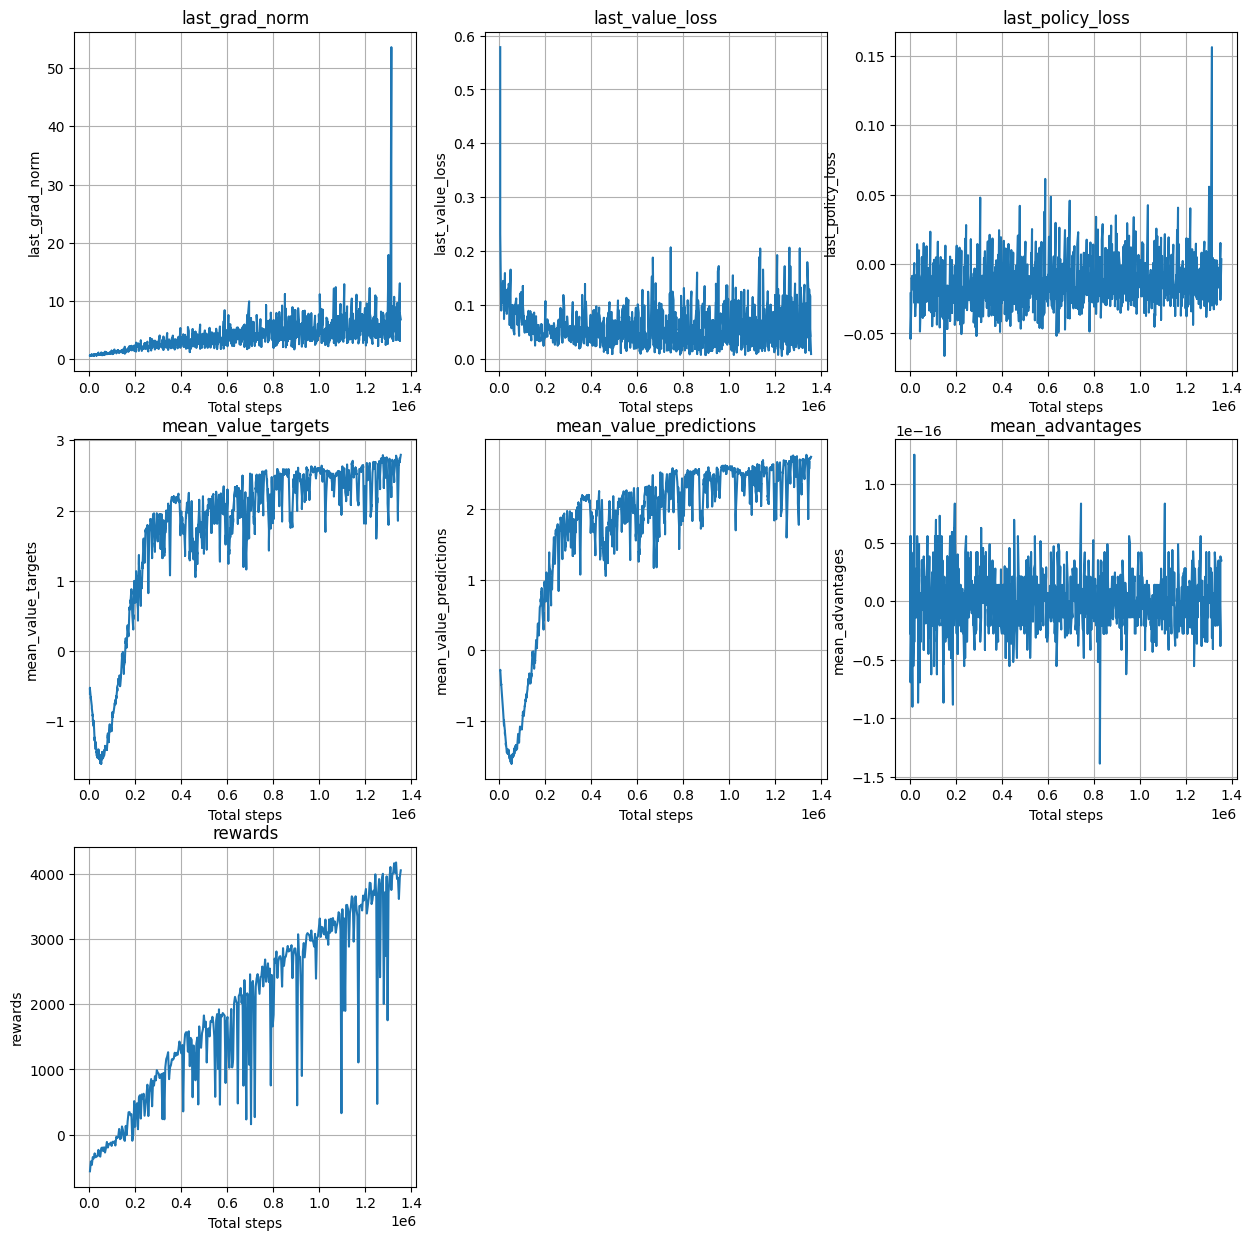

 71%|███████   | 105797/150000 [1:24:06<15:09, 48.59it/s]

In [ ]:
steps = []
logs = {key : [] for key in ppo.history.keys()}
logs['rewards'] = []

for i in tqdm(range(n_iter)):
    trajectory = sampler.get_next()

    if (i + 1) % 100 == 0:
        clear_output(True)
        logs['rewards'].append(vec_env.env.env.env.return_queue[-1])
        steps.append(sampler.runner.step_var)
        for key, value in ppo.history.items():
            logs[key].append(value)



        plt.figure(figsize=[15, 15])
        fig = 1
        for key, value in logs.items():
            plt.subplot(3, 3, fig)
            plt.title(key)
            plt.plot(steps, value)
            plt.xlabel("Total steps")
            plt.ylabel(key)
            plt.grid()
            fig += 1
        plt.show()

    ppo.step(trajectory)
    sched.step()

## Evaluation

In [ ]:
def evaluate(env, actor, n_games=1, t_max=1000):
    rewards = []
    for _ in range(n_games):
        s, _ = env.reset()
        R = 0
        for _ in tqdm(range(t_max)):
            action = actor.act(np.array([s]), training=False)["actions"]
            s, r, terminated, truncated, _ = env.step(action)
            R += r
            if terminated or truncated:
                break
        rewards.append(R)
    return np.array(rewards)